In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#  	Steuart at Market id74
- tripデータから得られる時系列と、statusデータから得られる時系列を比較
- 運営側の介入の有無を確認する。その上で、解決手段を提案する。

In [122]:
#trip データ
trip = pd.read_csv('/home/kyohei/bike_share_data/201608_trip_data.csv')

#スタートもしくはスタートがSteuart as Market
trip_ste = trip[(trip['Start Terminal']==65) | (trip['End Terminal'])]

In [123]:
import datetime
#スタートの時間情報の整理
#datetimeに変換
trip_ste['Start Date'] = trip_ste['Start Date'].apply(lambda x:pd.to_datetime(x))

#日付情報
trip_ste['start_day'] = trip_ste['Start Date'].apply(lambda x:x.date())

#曜日情報
trip_ste['start_dayofweek'] = trip_ste['Start Date'].apply(lambda x:x.dayofweek)

#時間情報
trip_ste['start_time'] = trip_ste['Start Date'].apply(lambda x:datetime.time(x.time().hour,x.time().minute))

#到着の時間情報の整理
#datetimeに変換
trip_ste['End Date'] = trip_ste['End Date'].apply(lambda x:pd.to_datetime(x))

#日付情報
trip_ste['end_day'] = trip_ste['End Date'].apply(lambda x:x.date())

#曜日情報
trip_ste['end_dayofweek'] = trip_ste['End Date'].apply(lambda x:x.dayofweek)

#時間情報
trip_ste['end_time'] = trip_ste['End Date'].apply(lambda x:datetime.time(x.time().hour,x.time().minute))

In [124]:
#貸出の時系列
rent_count = pd.DataFrame(trip_ste[trip_ste['Start Terminal']==65].groupby(['start_day','start_time']).size()).reset_index()
rent_count.rename(columns={0:'count'},inplace=True)

#返却の時系列
return_count = pd.DataFrame(trip_ste[trip_ste['End Terminal']==65].groupby(['end_day','end_time']).size()).reset_index()
return_count.rename(columns={0:'count'},inplace=True)

In [125]:
#status data
status = pd.read_csv('/home/kyohei/bike_share/data_split_2015/San Francisco_station_status_stid65.csv')

In [126]:
#datetimeに変換
status['time'] = status['time'].apply(lambda x:pd.to_datetime(x))

#日付情報
status['date'] = status['time'].apply(lambda x:x.date())

#曜日情報
status['dayofweek'] = status['time'].apply(lambda x:x.dayofweek)

#時間情報
status['hour_minute'] = status['time'].apply(lambda x:datetime.time(x.time().hour,x.time().minute))

In [127]:
status_merge = status.merge(rent_count,left_on=['date','hour_minute'],right_on=['start_day','start_time'],how='left')
status_merge_2 = status_merge.merge(return_count,left_on=['date','hour_minute'],right_on=['end_day','end_time'],how='left')

In [128]:
status_bikes_mean = pd.DataFrame(status_merge_2.groupby(['dayofweek','hour_minute'])['bikes_available'].mean()).reset_index()
status_docks_mean = pd.DataFrame(status_merge_2.groupby(['dayofweek','hour_minute'])['docks_available'].mean()).reset_index()

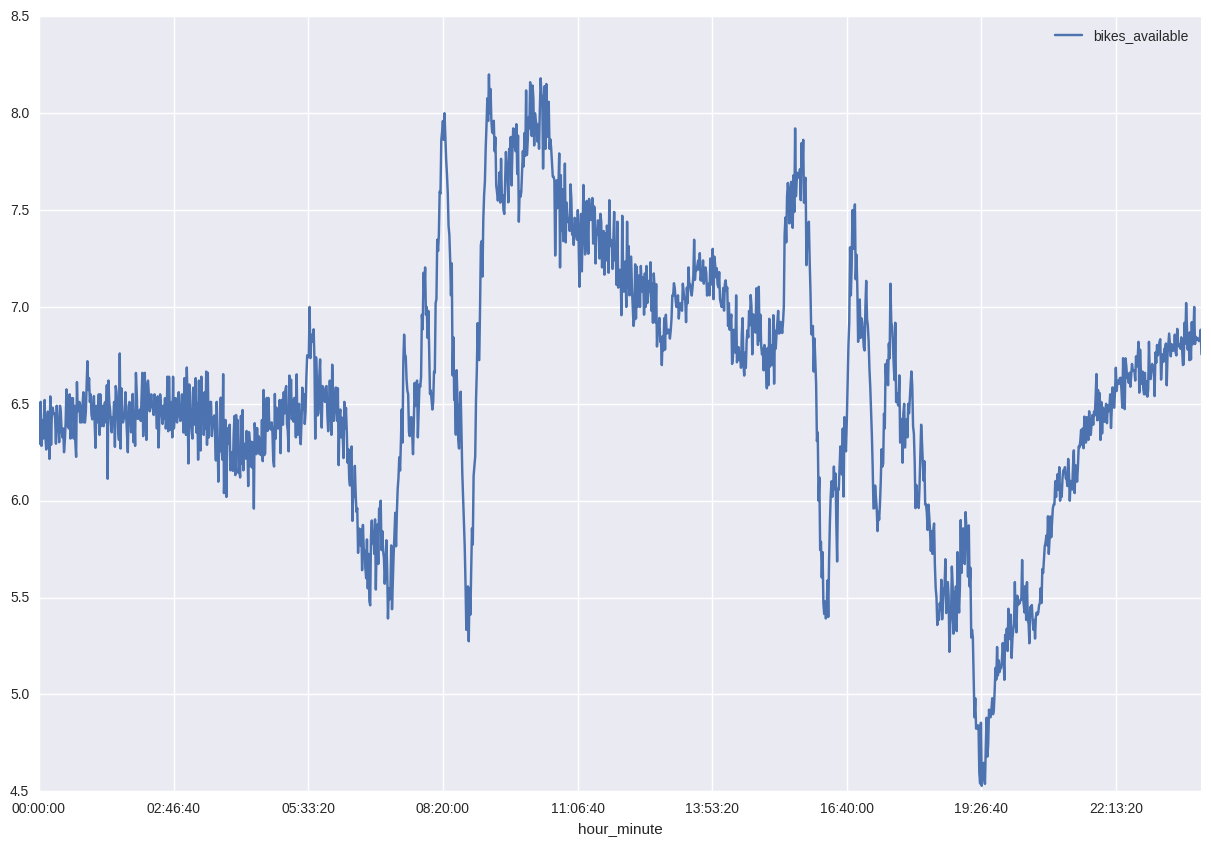

In [129]:
status_bikes_mean[status_bikes_mean.dayofweek==0].plot('hour_minute','bikes_available',figsize=(15,10))

In [130]:
trip_bikes_mean = pd.DataFrame(status_merge_2.fillna(0).groupby(['dayofweek','hour_minute'])['count_x'].mean()).reset_index()

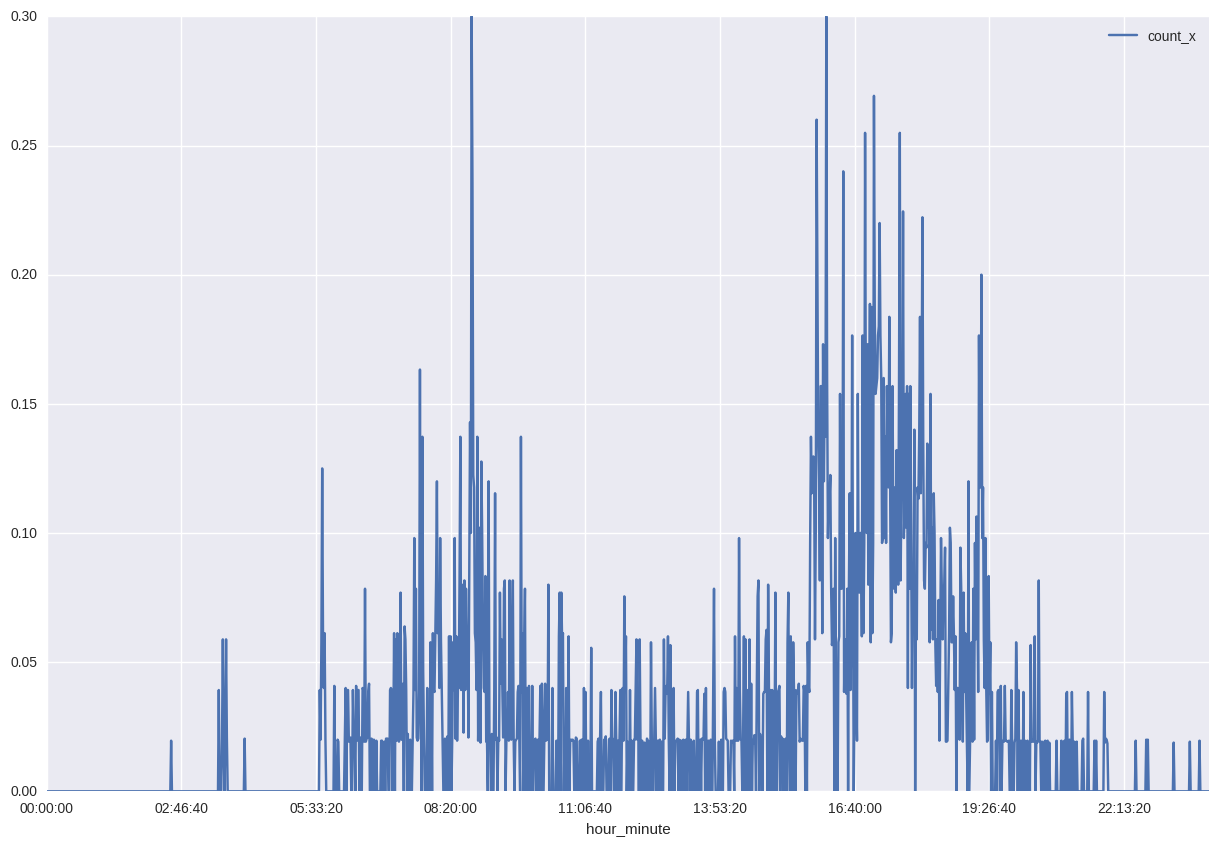

In [131]:
trip_bikes_mean[trip_bikes_mean.dayofweek==0].plot('hour_minute','count_x',figsize=(15,10))

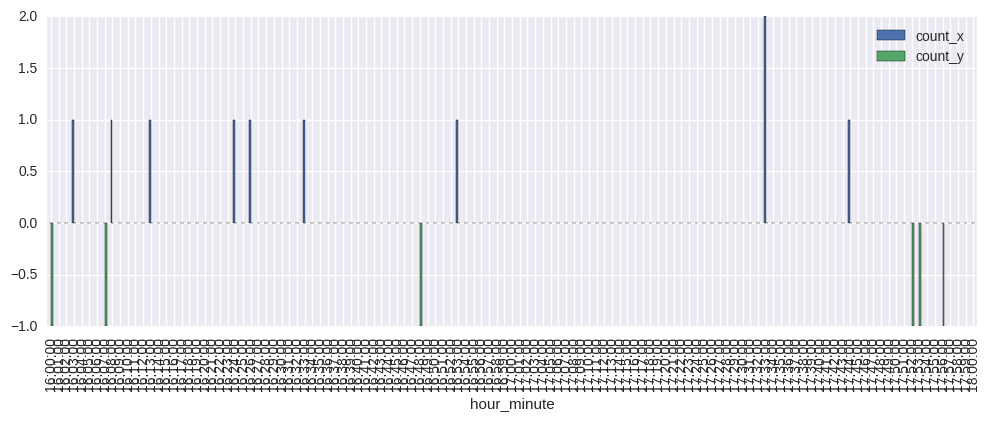

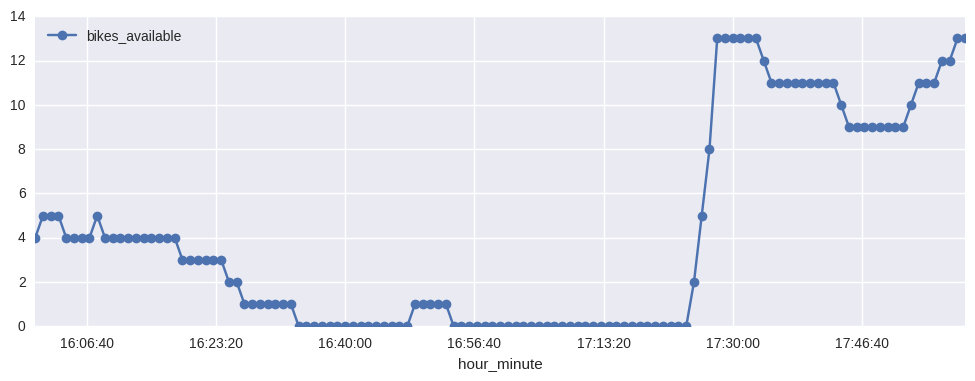

In [146]:
mask = (status_merge_2.date==datetime.date(2015,9,14)) \
& (status_merge_2.hour_minute>=datetime.time(16,0,0)) \
& (status_merge_2.hour_minute<=datetime.time(18,0,0))

status_merge_2[mask].plot('hour_minute',['count_x','count_y'],kind='bar',figsize=(12,4))
status_merge_2[mask].plot('hour_minute','bikes_available',style='-o',figsize=(12,4))

In [134]:
status_merge_2['count_y'] = -status_merge_2['count_y']

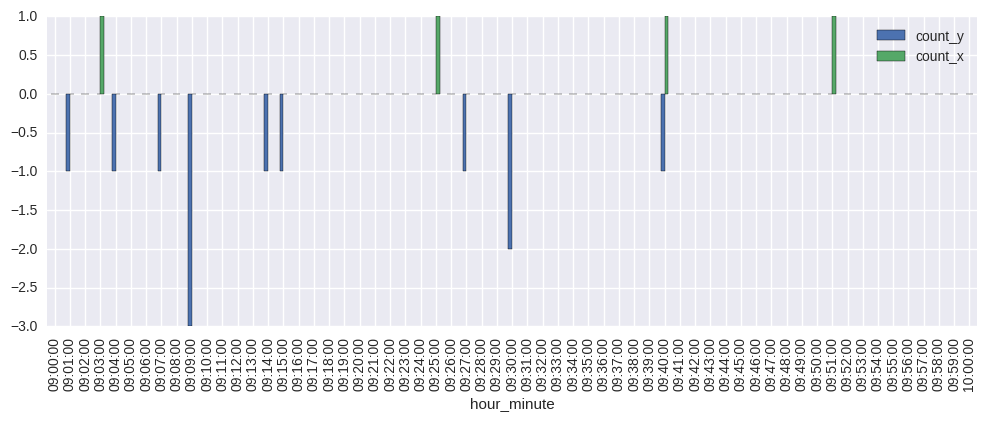

In [139]:
status_merge_2[mask].plot('hour_minute',['count_y','count_x'],kind='bar',figsize=(12,4))

In [147]:
status_merge_2.head()

,Unnamed: 0,station_id,bikes_available,docks_available,time,date,dayofweek,hour_minute,start_day,start_time,count_x,end_day,end_time,count_y
0,26850671,65,10,5,2015-09-01 00:00:02,2015-09-01,1,00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,26850672,65,10,5,2015-09-01 00:01:02,2015-09-01,1,00:01:00,NaN,NaN,NaN,NaN,NaN,NaN
2,26850673,65,10,5,2015-09-01 00:02:02,2015-09-01,1,00:02:00,NaN,NaN,NaN,NaN,NaN,NaN
3,26850674,65,10,5,2015-09-01 00:03:03,2015-09-01,1,00:03:00,NaN,NaN,NaN,NaN,NaN,NaN
4,26850675,65,10,5,2015-09-01 00:04:02,2015-09-01,1,00:04:00,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
trip_ste['start_hour'] = trip_ste['start_time'].apply(lambda x:x.hour)
trip_ste['end_hour'] = trip_ste['end_time'].apply(lambda x:x.hour)

In [155]:
status_merge_2['start_hour'] = status_merge_2['hour_minute'].apply(lambda x:x.hour)

In [164]:
status_per_hour = pd.DataFrame(status_merge_2.groupby(['date','dayofweek','start_hour'])['count_x','count_y'].sum().fillna(0)).reset_index()

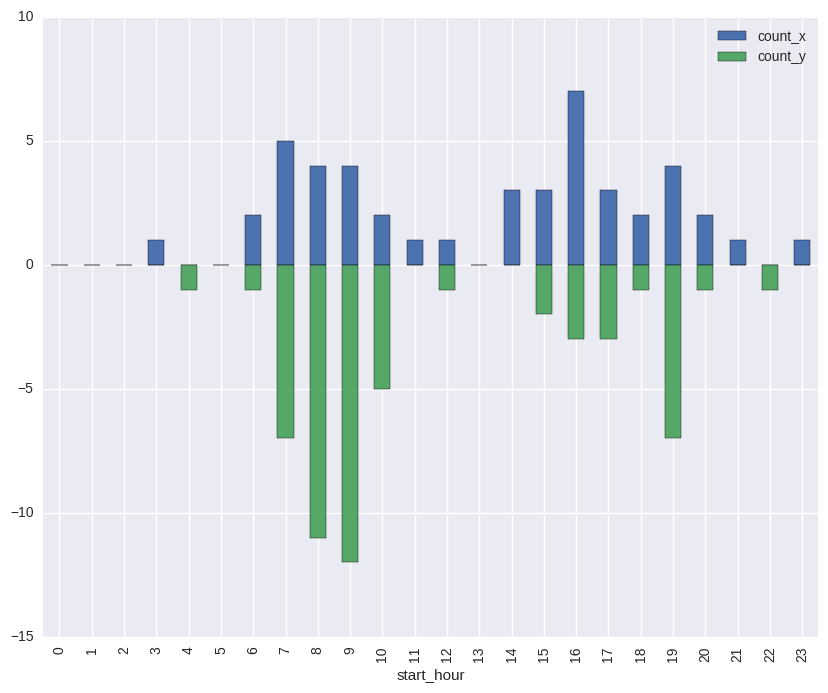

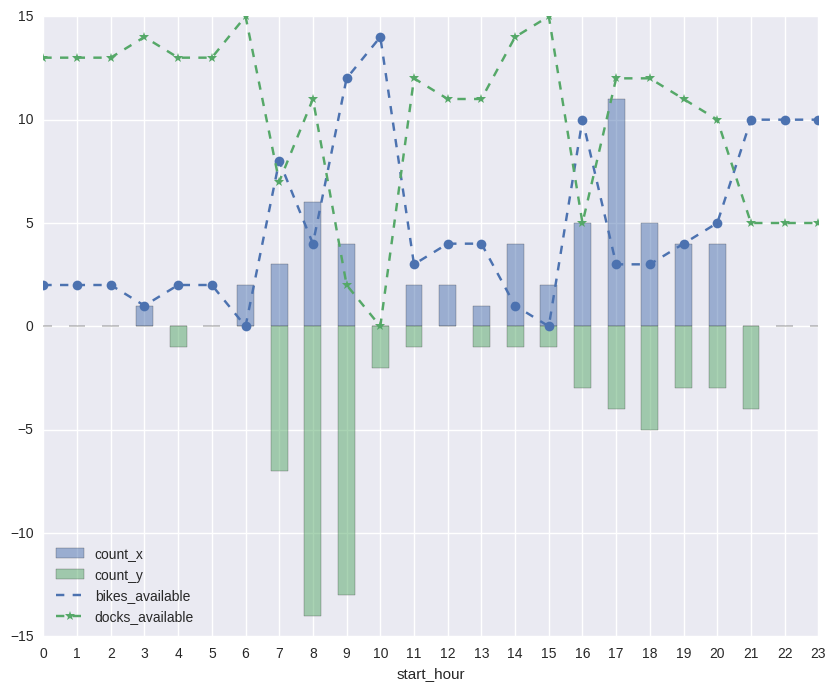

In [188]:
fig, axes = plt.subplots(1,1,figsize=(10,8))
status_per_hour[status_per_hour.date==datetime.date(2015,9,16)].plot('start_hour',['count_x','count_y'],kind='bar',figsize=(10,8),stacked=True,ax=axes,alpha=0.5)
status_merge_2[(status_merge_2.date==datetime.date(2015,9,16)) & (status_merge_2.minute==59)].plot('start_hour','bikes_available',figsize=(10,8),style='o--',ax=axes)
status_merge_2[(status_merge_2.date==datetime.date(2015,9,16)) & (status_merge_2.minute==59)].plot('start_hour','docks_available',figsize=(10,8),style='*--',ax=axes)

In [173]:
status_merge_2['minute'] = status_merge_2['hour_minute'].apply(lambda x:x.minute)